In [1]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import hinge_loss
import pandas as pd 
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import time
from scipy.sparse import hstack,csr_matrix
import cPickle as pickle
import random
# xgBoost AUC: 0.76833777818980442
# RF AUC: 0.75744520850500441

In [2]:
X=np.load('./pickledata/nxtrain_standard_original0.npy')
X1= np.load('./pickledata/nxtrain_standard_derived0.npy')
X2=pickle.load(open("./pickledata/time_series_derived_standard_train2.dat","rb"))
X3=pickle.load(open("./pickledata/time_series_original_standard_train2.dat","rb"))
X4=pickle.load(open("./pickledata/cat_numeric_th60_standard_train2.dat","rb"))
X5=pickle.load(open("./pickledata/cat_le_train2.dat","rb"))#label encoded categorical data 15 in total
y=pickle.load(open("./pickledata/ytrain2.dat","rb"))

In [3]:
X=np.hstack((X,X1,X2,X3,X4,X5))

In [4]:
def plot_roc(fpr, tpr):
    """Plot ROC curve and display it."""
    plt.clf()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.savefig('plots/ROC_curve.png')

    
def learning_curve(model, X_train, y_train, X_cv, y_cv,n=20):
    """Plot train and cv loss for increasing train sample sizes."""
    chunk = int(len(y)/n)
    n_samples = []
    train_losses = []
    cv_losses = []
    
    for i in range(n):
        train_subset = X_train[:(i + 1)*chunk]
        MD = model.fit(X_train[:(i + 1)*chunk], y_train[:(i + 1)*chunk])
        
        preds_train = model.predict_proba(X_train[:(i + 1)*chunk])
        preds_cv = model.predict_proba(X_cv)
        
        n_samples.append((i + 1)*chunk)
        cv_losses.append(hinge_loss(y_cv, preds_cv, labels=0))
        train_losses.append(hinge_loss(y_train[:(i + 1)*chunk], preds_train, labels=0))

    plt.gca()
    plt.plot(n_samples, train_losses, 'r--', n_samples, cv_losses, 'b--')
    plt.gca()
    plt.plot(n_samples, train_losses,'ro--',label='train_loss')
    plt.plot(n_samples, cv_losses, 'bd--',label='cv_loss')
    plt.legend(loc='best',fontsize='medium')
    plt.xlabel('sample size')
    plt.ylabel('hinge loss')
    plt.ylim([min(train_losses) - .01, max(cv_losses) + .01])

    plt.savefig('plots/learning_curve.png')
    plt.show()
    
def cv_loop(X, y, model, N, SEED=40, diagnostics=False, randomsplit=False):   # N random splits into train and test sets with the test of 1/N fraction
    # Return the ((mean and std of the cv AUC score), and fscore)
    AUC = np.zeros(N) 
    if N ==1:
        skf = cross_validation.StratifiedKFold(y, n_folds=2) # K-fold cv splitting
        if len(X.shape)==1:#to be compatible with forward selection
            fscore_total = 0
        else:
            fscore_total = np.zeros((X.shape[1],2)) #feature num * 2
    else:# N >=2 folds
        skf = cross_validation.StratifiedKFold(y, n_folds=N) # K-fold cv splitting
        if len(X.shape)==1:#to be compatible with forward selection
            fscore_total = 0
        else:
            fscore_total = np.zeros((X.shape[1],N)) #feature num * N-fold cv

    i=0
    for train, cv in skf:
        if randomsplit: # random split of the row index
            train, cv = cross_validation.train_test_split(range(len(y)), test_size=1.0/float(N), random_state = i*SEED)
            
        if len(X.shape)==1:
            MODEL = model.fit(X[train], y[train])
            preds_cv = model.predict_proba(X[cv])
        else:
            MODEL = model.fit(X[train,:], y[train])
            preds_cv = model.predict_proba(X[cv,:])
            fscore_cv = model.fscore #raw fscore dictionary eg ['f100':1]
            fscore_list =[[int(ftemp[1:]), vtemp] for ftemp, vtemp in fscore_cv.iteritems()]
            fscore_list.sort(key=lambda fv:fv[0])#sort based on the feature names(indices)
            #some features have no fscore, assumed to be 0
            fscore_features = [fscore_list_temp[0] for fscore_list_temp in fscore_list]
            fscore_values =   [fscore_list_temp[1] for fscore_list_temp in fscore_list]
            fscore_total[fscore_features,i] = fscore_values#fill in for the i-th fold
        
        fpr, tpr, _ = metrics.roc_curve(y[cv], preds_cv)
        roc_auc = metrics.auc(fpr, tpr)
    
        AUC[i] = roc_auc

        # plot learning curve and roc curve for diagonistics purpose
        if diagnostics and i == 0:  # only plot for first fold
            print("plotting ROC curve")
            plot_roc(fpr, tpr)
            print("plotting learning curve")
            if len(X.shape)==1:
                learning_curve(model, X[train], y[train], X[cv,:], y[cv])
            else:
                learning_curve(model, X[train,:], y[train], X[cv,:], y[cv])
        i+=1
        if N==1: #for N=1, since minimum N should be 2 in StratifiedKFold
            #duplicate the fscore
            fscore_total[:,1]=fscore_total[:,0]
            mean_auc = AUC
            std_auc = 0
            break
    if N>1:
        mean_auc = AUC.mean()
        std_auc = AUC.std()
        
    if len(X.shape)==1:
        fscore = 0
    else:
        fscore = fscore_total.mean(axis=1)
    
    return ((mean_auc, std_auc), fscore) 

In [5]:
def feature_selection_backward(model, params, Xtrain, ytrain, diagonistics=False, SEED=42, num_rows=10000, drop_features_percent=0.1, feature_num_thresh=10, n_cv_rounds = 2, auc_prec=10000,auc_prec2=10000):
    "Backward feature selection using feature importance in xgboost"

    print "Performing backward feature selection..."
    score_hist = []
    total_features = np.asarray(range(Xtrain.shape[1])) #all the columns, fixed column numbers for all the features
    good_features = total_features #column of the features in the original matrix
    use_features = total_features[good_features]#the column being used
    userows_hist=[]#check random number generator
    
    MODEL = model.set_params(random_state=SEED)
    MODEL.set_params(params=params)
    
    bestAUC=0
    
    while len(good_features)>=feature_num_thresh: #stop when there are feature_num_thresh features left 
        scores = []    
        if num_rows < Xtrain.shape[0]:
            #random sampling for stochastic feature selection
            userows = sorted(random.sample(range(Xtrain.shape[0]), num_rows))
        else:
            #use all the rows
            userows = range(Xtrain.shape[0])     
        if userows == userows_hist and num_rows < Xtrain.shape[0]:
            userows = sorted(random.sample(range(Xtrain.shape[0]), num_rows))
            print('Two randomly chosen lists appeared to be the same')
        userows_hist = userows
        
        #get the fscore of all the features using a cv_loop
        score, fscore_temp = cv_loop(Xtrain[userows, :][:,use_features], ytrain[userows], MODEL, N=n_cv_rounds)
        
        if round(score[0] * auc_prec) >= round(bestAUC * auc_prec):
            bestAUC = score[0]
            score_hist.append(bestAUC) 
            print('\t\t\t\t %d features left. Current AUC: %f' % ( len(good_features), bestAUC))
            #save results
            str1=time.strftime("%b%d%Y_%H%M%S", time.localtime())
            with open(('XGBoost_backward_selection_' + str(len(use_features)) +'Features '+str1 + '_AUC_' + '0p'+ str(int(bestAUC*1e5))  +'.p'), 'wb') as f:
                pickle.dump(use_features, f, protocol =2)
            with open(('fscores_' + str(len(use_features)) +'Features '+str1 + '_AUC_' + '0p'+ str(int(bestAUC*1e5))  +'.p'), 'wb') as f2:
                pickle.dump(fscore_temp, f2, protocol =2)
            
            #drop redundant features
            #fscore_temp is an array corresponding to the fscores of the good features being used.
            fscore_sorted_index = np.argsort(fscore_temp)[::-1]         
            good_feature_rows = int(len(fscore_sorted_index) * (1- drop_features_percent))#how many rows to keep
            
            good_features = fscore_sorted_index[0:good_feature_rows]#index in the current use_feature
            other_features  = fscore_sorted_index[good_feature_rows:]#index in the current use_feature
            #update hist_features first, since use_features itself will be updated shortly
            hist_features = use_features[other_features]#use_features contain the indices in the total_features
            #update use_features, to be used in next loop
            use_features  = use_features[good_features] #use_features contain the indices in the total_features
        else:
            #score is not better than the last bestAUC
            #recover the dropped features one by one till the AUC is >= bestAUC
            #break if all features dropped in the last step are recovered
            bestAUC_recover = 0
            score_hist.append(score[0]) #show the trend
            with open(('XGBoost_backward_selection_' + str(len(use_features)) +'Features '+str1 + '_AUC_' + '0p'+ str(int(bestAUC*1e5))  +'.p'), 'wb') as f3:
                pickle.dump(use_features, f3, protocol =2)
            with open(('fscores_' + str(len(use_features)) +'Features '+str1 + '_AUC_' + '0p'+ str(int(bestAUC*1e5))  +'.p'), 'wb') as f4:
                pickle.dump(fscore_temp, f4, protocol =2)
                
            print('AUC found in this step (%f) is worse than %f in the last step. Recovering features from %d features' %(score[0], bestAUC, len(hist_features)))
            for f in range(len(hist_features)):                           
                use_features = np.append(use_features, hist_features[f])
                score, fscore_temp = cv_loop(Xtrain[userows, :][:,use_features], ytrain[userows], MODEL, N=n_cv_rounds)
                score_hist.append(score[0])
                if round(score[0] * auc_prec2) >= round(bestAUC * auc_prec2):
                    if round(score[0] * auc_prec2) >= round(bestAUC_recover * auc_prec2):
                        bestAUC_recover = score[0] #found it, but let's keep improving.
                    else:
                        break;#found it. And we cannot do better. 
                
            bestAUC = score[0] #or all the hist_features are included 
            #save results
            str1=time.strftime("%b%d%Y_%H%M%S", time.localtime())
            with open(('XGBoost_backward_selection_' + str(len(use_features)) +'Features '+str1 + '_AUC_' + '0p'+ str(int(bestAUC*1e5))  +'.p'), 'wb') as f5:
                pickle.dump(use_features, f5, protocol =2)
            
            print('All good hist_features recovered, no more selection is necessary.')
            print('Final best AUC is %f' % bestAUC)
            break #the while loop           
            
    if diagonistics:
        plt.clf()
        plt.plot(range(len(score_hist)),score_hist,'ro--')
        plt.xlabel('Feature selection step')
        plt.ylabel('AUC score')
        plt.title('Feature-selection curve')
        plt.savefig('plots/featsel_curve.png')
    
    print('Feature selection done: %d features selected'%len(use_features))
    
    return use_features

In [6]:
class XGBoostClassifier():
    def __init__(self, num_boost_round=10, **params):
        self.clf = None
        self.num_boost_round = num_boost_round
        self.params = params
        self.params.update({'objective': 'binary:logistic'})
 
    def fit(self, X, y, num_boost_round=None):
        num_boost_round = num_boost_round or self.num_boost_round
        dtrain = xgb.DMatrix(X, label=y)
        self.clf = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=num_boost_round)
        self.fscore = self.clf.get_fscore()
        
    def predict(self, X):
        num2label = {i: label for label, i in self.label2num.items()}
        Y = self.predict_proba(X)
        y = np.argmax(Y, axis=1)
        return np.array([num2label[i] for i in y])
 
    def predict_proba(self, X):
        dtest = xgb.DMatrix(X)
        return self.clf.predict(dtest)
 
    def score(self, X, y):
        Y = self.predict_proba(X)
        return 1 / self.logloss(y, Y)
 
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        if 'num_boost_round' in params:
            self.num_boost_round = params.pop('num_boost_round')
        if 'objective' in params:
            del params['objective']
        self.params.update(params)
        return self
    
    
    def logloss(self,y_true, Y_pred):
        label2num = dict((name, i) for i, name in enumerate(sorted(set(y_true))))
        return -1 * sum(math.log(y[label2num[label]]) if y[label2num[label]] > 0 else -np.inf \
                        for y, label in zip(Y_pred, y_true)) / len(Y_pred)

In [7]:
xgbclassifier = XGBoostClassifier(num_boost_round=50)

In [8]:
params = {'max_depth':14, 
             'eta':0.01, 
             'objective':'binary:logistic', 
             'subsample':0.6,
             'colsample_bytree':0.6,
             'eval_metric': 'auc'}

Performing backward feature selection...
				 1762 features left. Current AUC: 0.772257
				 1409 features left. Current AUC: 0.772358
				 1127 features left. Current AUC: 0.772297
				 901 features left. Current AUC: 0.772328
				 720 features left. Current AUC: 0.772457
				 576 features left. Current AUC: 0.772327
AUC found in this step (0.771375) is worse than 0.772327 in the last step. Recovering features from 116 features
All good hist_features recovered, no more selection is necessary.
Final best AUC is 0.772285
Feature selection done: 487 features selected
Time elapsed = 163.514066668


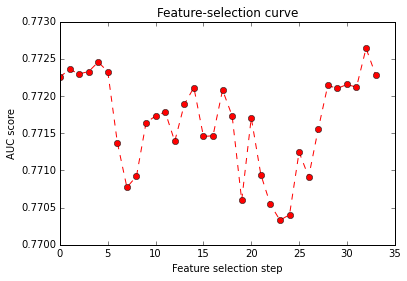

In [9]:
tic_total = time.time()
features=feature_selection_backward(xgbclassifier, params, X, y, diagonistics=True, SEED=42, num_rows=X.shape[0], drop_features_percent=0.2, feature_num_thresh=10, n_cv_rounds=5, auc_prec=1000, auc_prec2=10000)
elapsed_total = time.time() - tic_total
print ('Time elapsed = {}'.format(elapsed_total/60))